# Однослойный перцептрон
Демонстрация с цветочком

In [46]:
import numpy as np

# Функция активации нейрона в выходном слое и ее производная
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
def dsigmoid(y):
    return y * (1 - y)

# Функция активации нейронов во внутреннем слое и ее производная
def tanh(x):
    return np.tanh(x)
def dtanh(y):
    return 1 - y * y

In [47]:
from matplotlib import pyplot as plt

class Perceptron:
    def __init__(self, X, Y, hidden_size):

        # Пусть n - количество признаков, m - количество объектов, k - размерность результирующего вектора
        # Тогда X = X(n * m), Y = Y(k, m)
        assert X.shape[1] == Y.shape[1]
        self.X = X
        self.Y = Y
        self.m = X.shape[1]

        # Инициализируем матрицы весов рандомными числами (W1 - для скрытого слоя, W2 - для выходного, в нем всего 1 нейрон)
        self.W1 = np.random.randn(hidden_size, X.shape[0])
        self.W2 = np.random.randn(Y.shape[0], hidden_size)

        # Заполняем свободные векторы нулями
        self.b1 = np.zeros((hidden_size, 1))
        self.b2 = np.zeros((Y.shape[0], 1))

        # Здесь будем накапливать значения функции потерь на каждой итерации
        self.ce_loss = []
        self.mse_loss = []

    def learn(self, epochs, learning_rate, lmdb): # добавили параметр lmbd

        # Итерируемся необходимое количество раз
        for i in range(epochs):

            # Прямое распространение
            Z1 = np.dot(self.W1, self.X) + self.b1
            A1 = tanh(Z1)
            Z2 = np.dot(self.W2, A1) + self.b2
            A2 = sigmoid(Z2)

            # Функция потерь (MSE с регуляризацией)
            mse_loss = (np.sum((A2 - self.Y) ** 2) + (lmdb / (2 * self.m)) * (np.sum(self.W1**2) + np.sum(self.W2**2))) / self.m
            self.mse_loss.append(mse_loss)

            # Функция потерь (CE)
            epsilon = 1e-12  # защита от логарифма нуля
            A2_clipped = np.clip(A2, epsilon, 1 - epsilon)
            ce_loss = -np.sum(self.Y * np.log(A2_clipped) + (1 - self.Y) * np.log(1 - A2_clipped)) / self.m
            self.ce_loss.append(ce_loss)

            if i % 1000 == 0:
                print(f"Epoch {i}: MSE loss = {mse_loss}, CE loss = {ce_loss}")

            # Обратное распространение (модифицировано)
            dA2 = (A2 - self.Y) * A2 * (1 - A2)
            dW2 = np.dot(dA2, A1.T) + (lmdb / self.m) * self.W2
            db2 = np.sum(dA2, axis=1, keepdims=True)
            dA1 = np.dot(self.W2.T, dA2) * (1 - A1**2)
            dW1 = np.dot(dA1, self.X.T) + (lmdb / self.m) * self.W1
            db1 = np.sum(dA1, axis=1, keepdims=True)

            # Обновление параметров
            self.W2 -= learning_rate * dW2
            self.b2 -= learning_rate * db2
            self.W1 -= learning_rate * dW1
            self.b1 -= learning_rate * db1

        # Отображение графиков
        self.plot()

    def plot(self):
        """Визуализация графиков функции потерь"""
        plt.plot(self.mse_loss, label="MSE Loss")
        plt.plot(self.ce_loss, label="CE Loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Training Loss")
        plt.legend()
        plt.show()

    def predict(self, X):
        # используем найденные матрицы весов
        A1 = tanh(np.dot(self.W1, X) + self.b1)
        A2 = sigmoid(np.dot(self.W2, A1) + self.b2)
        return (A2[0] > 0.5).astype(int)

## Разделение цветочка

In [48]:
# Создать датасет в виде цветочка, m - кол-во объектов (целое больше 1), a - максимальная длина листа (float больше 0)
def create_flower(m, a):
    D = 2
    N = int(m/2)
    X = np.zeros((m,D))
    Y = np.zeros((m,1), dtype='uint8')
    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2
        r = a*np.sin(4*t) + np.random.randn(N)*0.2
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
    return X.T, Y.T

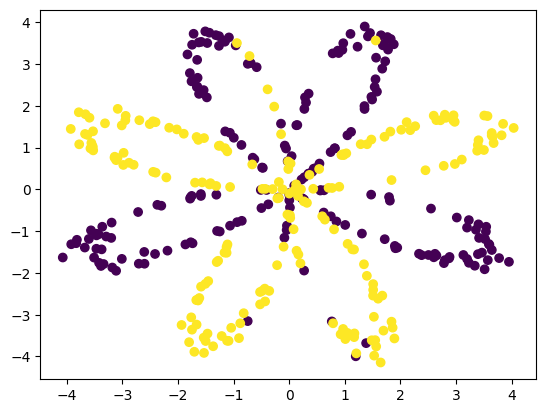

In [49]:
# Создаем и рисуем датасет в форме цветочка с 200 объектами, цветами обозначены метки классов
X, Y = create_flower(400, 4) #данная функция определена ранее
plt.scatter(X[0, :], X[1, :], c=Y);

In [50]:
# Строим разделяющую  прямую, показывающую результат обучения нейросети
def plot_division(perceptron):
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = perceptron.predict(np.c_[xx.ravel(), yy.ravel()].T)
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=Y, cmap=plt.cm.Spectral);

### Один нейрон

Epoch 0: MSE loss = 0.2567715104557213, CE loss = 0.7067006893284308
Epoch 1000: MSE loss = 0.22527860587125115, CE loss = 0.6430153147750559
Epoch 2000: MSE loss = 0.22437779330166735, CE loss = 0.6411527789735649
Epoch 3000: MSE loss = 0.22383376124138393, CE loss = 0.6400224426950966
Epoch 4000: MSE loss = 0.22345151987160933, CE loss = 0.6392242452565606
Epoch 5000: MSE loss = 0.22316424680154434, CE loss = 0.6386219222196127
Epoch 6000: MSE loss = 0.2229389826035689, CE loss = 0.6381480760315716
Epoch 7000: MSE loss = 0.22275683197122734, CE loss = 0.6377638958429691
Epoch 8000: MSE loss = 0.2226060118141192, CE loss = 0.6374450796239239
Epoch 9000: MSE loss = 0.2224787433072205, CE loss = 0.6371755284884851


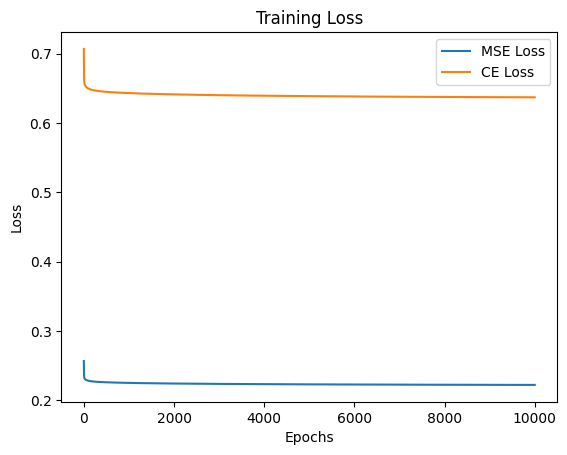

In [51]:
# Создаём объект класса Perceptron
perceptron = Perceptron(X, Y, 1)

# Вызываем метод learn с параметром регуляризации
perceptron.learn(epochs=10000, learning_rate=0.01, lmdb=0)

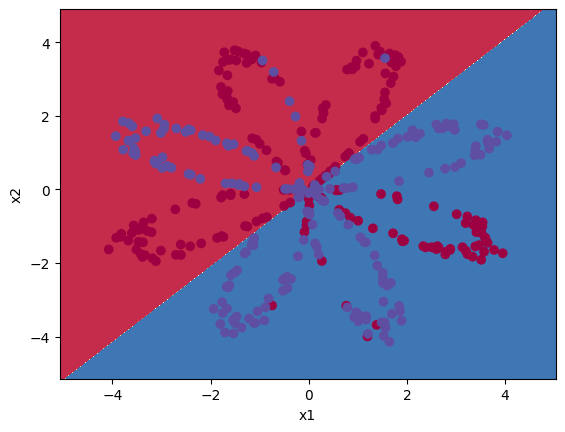

In [52]:
# Строим разделяющую  прямую, показывающую результат обучения нейросети
plot_division(perceptron)

### Четыре нейрона

Epoch 0: MSE loss = 0.31324745418992017, CE loss = 0.9730171942731991
Epoch 1000: MSE loss = 0.069330466982718, CE loss = 0.24504054972531597
Epoch 2000: MSE loss = 0.06560247386852196, CE loss = 0.2459686075280585
Epoch 3000: MSE loss = 0.06384284502835989, CE loss = 0.24178602581437061
Epoch 4000: MSE loss = 0.06297943936861616, CE loss = 0.2410037952055236
Epoch 5000: MSE loss = 0.06242730397169909, CE loss = 0.24057167757810277
Epoch 6000: MSE loss = 0.06201874967799257, CE loss = 0.2402136331499721
Epoch 7000: MSE loss = 0.0616864475329355, CE loss = 0.23988878866358987
Epoch 8000: MSE loss = 0.06139978108521808, CE loss = 0.239600453329882
Epoch 9000: MSE loss = 0.06114376907139413, CE loss = 0.2393575866756762


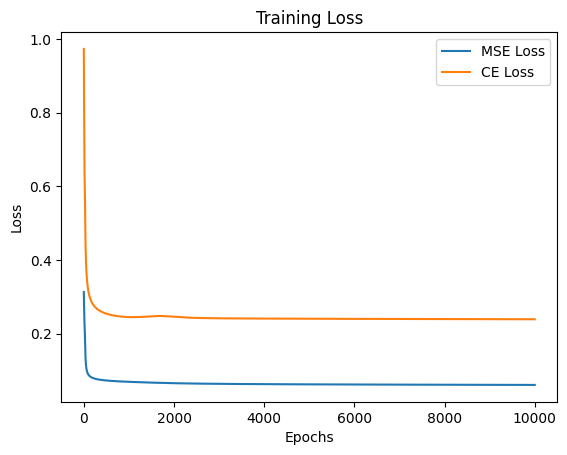

In [259]:
# Создаём объект класса Perceptron
perceptron = Perceptron(X, Y, 4)

# Вызываем метод learn с параметром регуляризации
perceptron.learn(epochs=10000, learning_rate=0.01, lmdb=0)

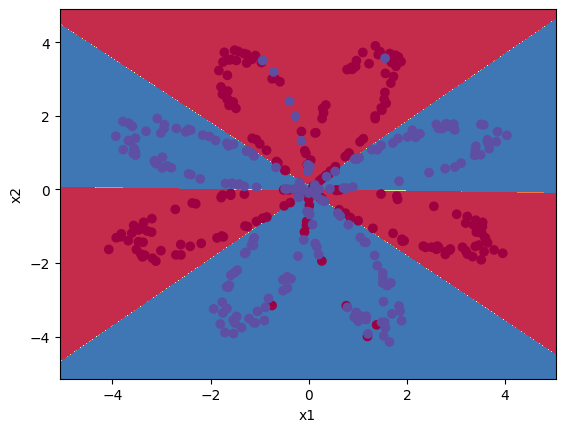

In [101]:
plot_division(perceptron)

### много нейронов - стало ли лучше?

Epoch 0: MSE loss = 0.6116258546571158, CE loss = 3.3893902992006373
Epoch 1000: MSE loss = 0.2971850544660477, CE loss = 1.8418888226710055
Epoch 2000: MSE loss = 0.28984016921203815, CE loss = 1.4929849975259537
Epoch 3000: MSE loss = 0.13777724725402404, CE loss = 0.44586767791148646
Epoch 4000: MSE loss = 0.09437493252445961, CE loss = 0.32971416048915303
Epoch 5000: MSE loss = 0.08887189821938789, CE loss = 0.3139137637328257
Epoch 6000: MSE loss = 0.08649174962949503, CE loss = 0.3079830125365593
Epoch 7000: MSE loss = 0.08505038904104525, CE loss = 0.30484481856414325
Epoch 8000: MSE loss = 0.08403294566740614, CE loss = 0.3028547130635842
Epoch 9000: MSE loss = 0.0832511751633592, CE loss = 0.30143766222846624
Epoch 10000: MSE loss = 0.08261799405300041, CE loss = 0.30034261201104184
Epoch 11000: MSE loss = 0.08208658756785074, CE loss = 0.29944337242387126
Epoch 12000: MSE loss = 0.08162904253416273, CE loss = 0.2986699381546775
Epoch 13000: MSE loss = 0.08122742030944995, CE 

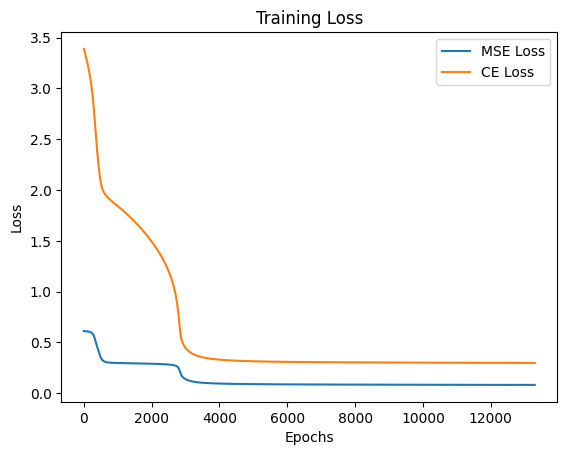

In [250]:
# Создаём объект класса Perceptron
perceptron = Perceptron(X, Y, 40)

# Вызываем метод learn с параметром регуляризации
perceptron.learn(epochs=13300, learning_rate=0.00004, lmdb=0.01)

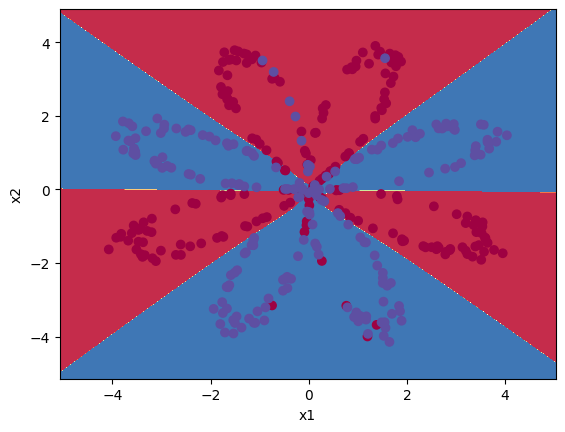

In [251]:
plot_division(perceptron)